In [15]:
import geopandas as gpd
import rioxarray as rxr
import numpy as np
import os
from rasterstats import zonal_stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from shapely.errors import ShapelyDeprecationWarning
from glob import glob
from rioxarray.merge import merge_arrays
import rasterio
from shapely.geometry import Polygon, Point
import random
import pickle
import shutil
import importlib
import pandas as pd
from glob import glob
#suppress ShapelyDeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

def recreate_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path

def load_config(path):
    spec = importlib.util.spec_from_file_location("CFG", path)
    CFG = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(CFG)
    return CFG

In [16]:
DATA_DIR = "data/grodzisko_20230111"
CFG = load_config(f"{DATA_DIR}/config.py").EXPLORATION

CACHE_DIR = f"{DATA_DIR}/cache"
GEOTIF_UNCAL_DIR = f"{DATA_DIR}/geotif_raw"
GEOTIF_CAL_DIR = f"{DATA_DIR}/geotif_cal"
CENTERLINE_PATH = f"{DATA_DIR}/centerline.json"

# Points at water body

In [17]:
#open data/centerline.json
centerline = gpd.read_file(CENTERLINE_PATH)
#reproject centerline to 'epsg:32634'
centerline = centerline.to_crs(CFG.CRS)
#generate points along centerline every 0.1 meters
#distance_delta = 5
distance_delta = 2
distances = np.arange(0, centerline.length[0], distance_delta)
points = [centerline.geometry.interpolate(distance)[0] for distance in distances]
river_pts_gdf = gpd.GeoDataFrame({'geometry': points, 'chainage': distances}, crs=CFG.CRS)
#buffer points to 0.1 meters
river_pts_gdf["geometry"] = river_pts_gdf.buffer(CFG.CENTERLINE_POINTS_BUFFER)
#load cached footprints
footprints = pickle.load(open(f"{CACHE_DIR}/footprints.pkl", "rb"))
#add to footprints a column that contains the indexes of polygons from river_pts_gdf that intersect with the footprint
footprints["river_pts_idx"] = footprints.geometry.apply(lambda x: river_pts_gdf[river_pts_gdf.intersects(x)].index.values)

In [18]:
if CFG.CACHE and os.path.exists(f"{CACHE_DIR}/exploration_uncal.pkl"):
    df_uncal = pd.read_pickle(f"{CACHE_DIR}/exploration_uncal.pkl")
else:
    temperatures = []
    chainages = []
    times = []
    
    for footprint in tqdm(footprints.itertuples(), total=len(footprints)):
        time = datetime.strptime(footprint.name.split("_")[1], "%Y%m%d%H%M%S")
        raster = rxr.open_rasterio(f"{GEOTIF_UNCAL_DIR}/{footprint.name}")
        geometries = [river_pts_gdf.geometry[idx] for idx in footprint.river_pts_idx]
        stats = zonal_stats(geometries, raster.values[0], stats="mean", affine=raster.rio.transform(), nodata=raster.rio.nodata)
        for j, stat in zip(footprint.river_pts_idx, stats):
            if stat["mean"] != None:
                if stat["mean"] < raster.rio.nodata:
                    print(footprint.name)
                temperatures.append(stat["mean"])
                chainages.append(river_pts_gdf["chainage"][j])
                times.append(time)
    timestamps = [(time.timestamp() - min(times).timestamp())/60 for time in times]
    df_uncal = pd.DataFrame({"temperature": temperatures, "chainage": chainages, "time": timestamps})
    df_uncal.to_pickle(f"{CACHE_DIR}/exploration_uncal.pkl")

100%|██████████| 1202/1202 [03:40<00:00,  5.46it/s]


In [19]:
# footprints = footprints[30:]

In [20]:
temperatures = []
chainages = []
times = []
for footprint in tqdm(footprints.itertuples(), total=len(footprints)):
    time = datetime.strptime(footprint.name.split("_")[1], "%Y%m%d%H%M%S")
    raster = rxr.open_rasterio(f"{GEOTIF_CAL_DIR}/{footprint.name}")
    geometries = [river_pts_gdf.geometry[idx] for idx in footprint.river_pts_idx]
    stats = zonal_stats(geometries, raster.values[0], stats="mean", affine=raster.rio.transform(), nodata=raster.rio.nodata)
    for j, stat in zip(footprint.river_pts_idx, stats):
        if stat["mean"] != None:
            # if stat["mean"] < raster.rio.nodata:
            #     print(footprint.name)
            temperatures.append(stat["mean"])
            chainages.append(river_pts_gdf["chainage"][j])
            times.append(time)
timestamps = [(time.timestamp() - min(times).timestamp())/60 for time in times]
df_cal = pd.DataFrame({"temperature": temperatures, "chainage": chainages, "time": timestamps})

100%|██████████| 1202/1202 [03:23<00:00,  5.91it/s]


In [21]:
#calculate mean and std of temperature for each chainage for uncalibrated and calibrated
uncalibrated_means = df_uncal.groupby("chainage").mean()["temperature"]
calibrated_means = df_cal.groupby("chainage").mean()["temperature"]
uncalibrated_stds = df_uncal.groupby("chainage").std()["temperature"]
calibrated_stds = df_cal.groupby("chainage").std()["temperature"]
print(uncalibrated_stds.mean())
print(calibrated_stds.mean())

0.5769016004037154
0.3099060818673268


In [22]:
valid_chainages = calibrated_stds[calibrated_stds < 1.0].index

In [28]:
df_uncal["temperature"] = df_uncal["temperature"] + 2.0
df_cal["temperature"] = df_cal["temperature"] + 2.0

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


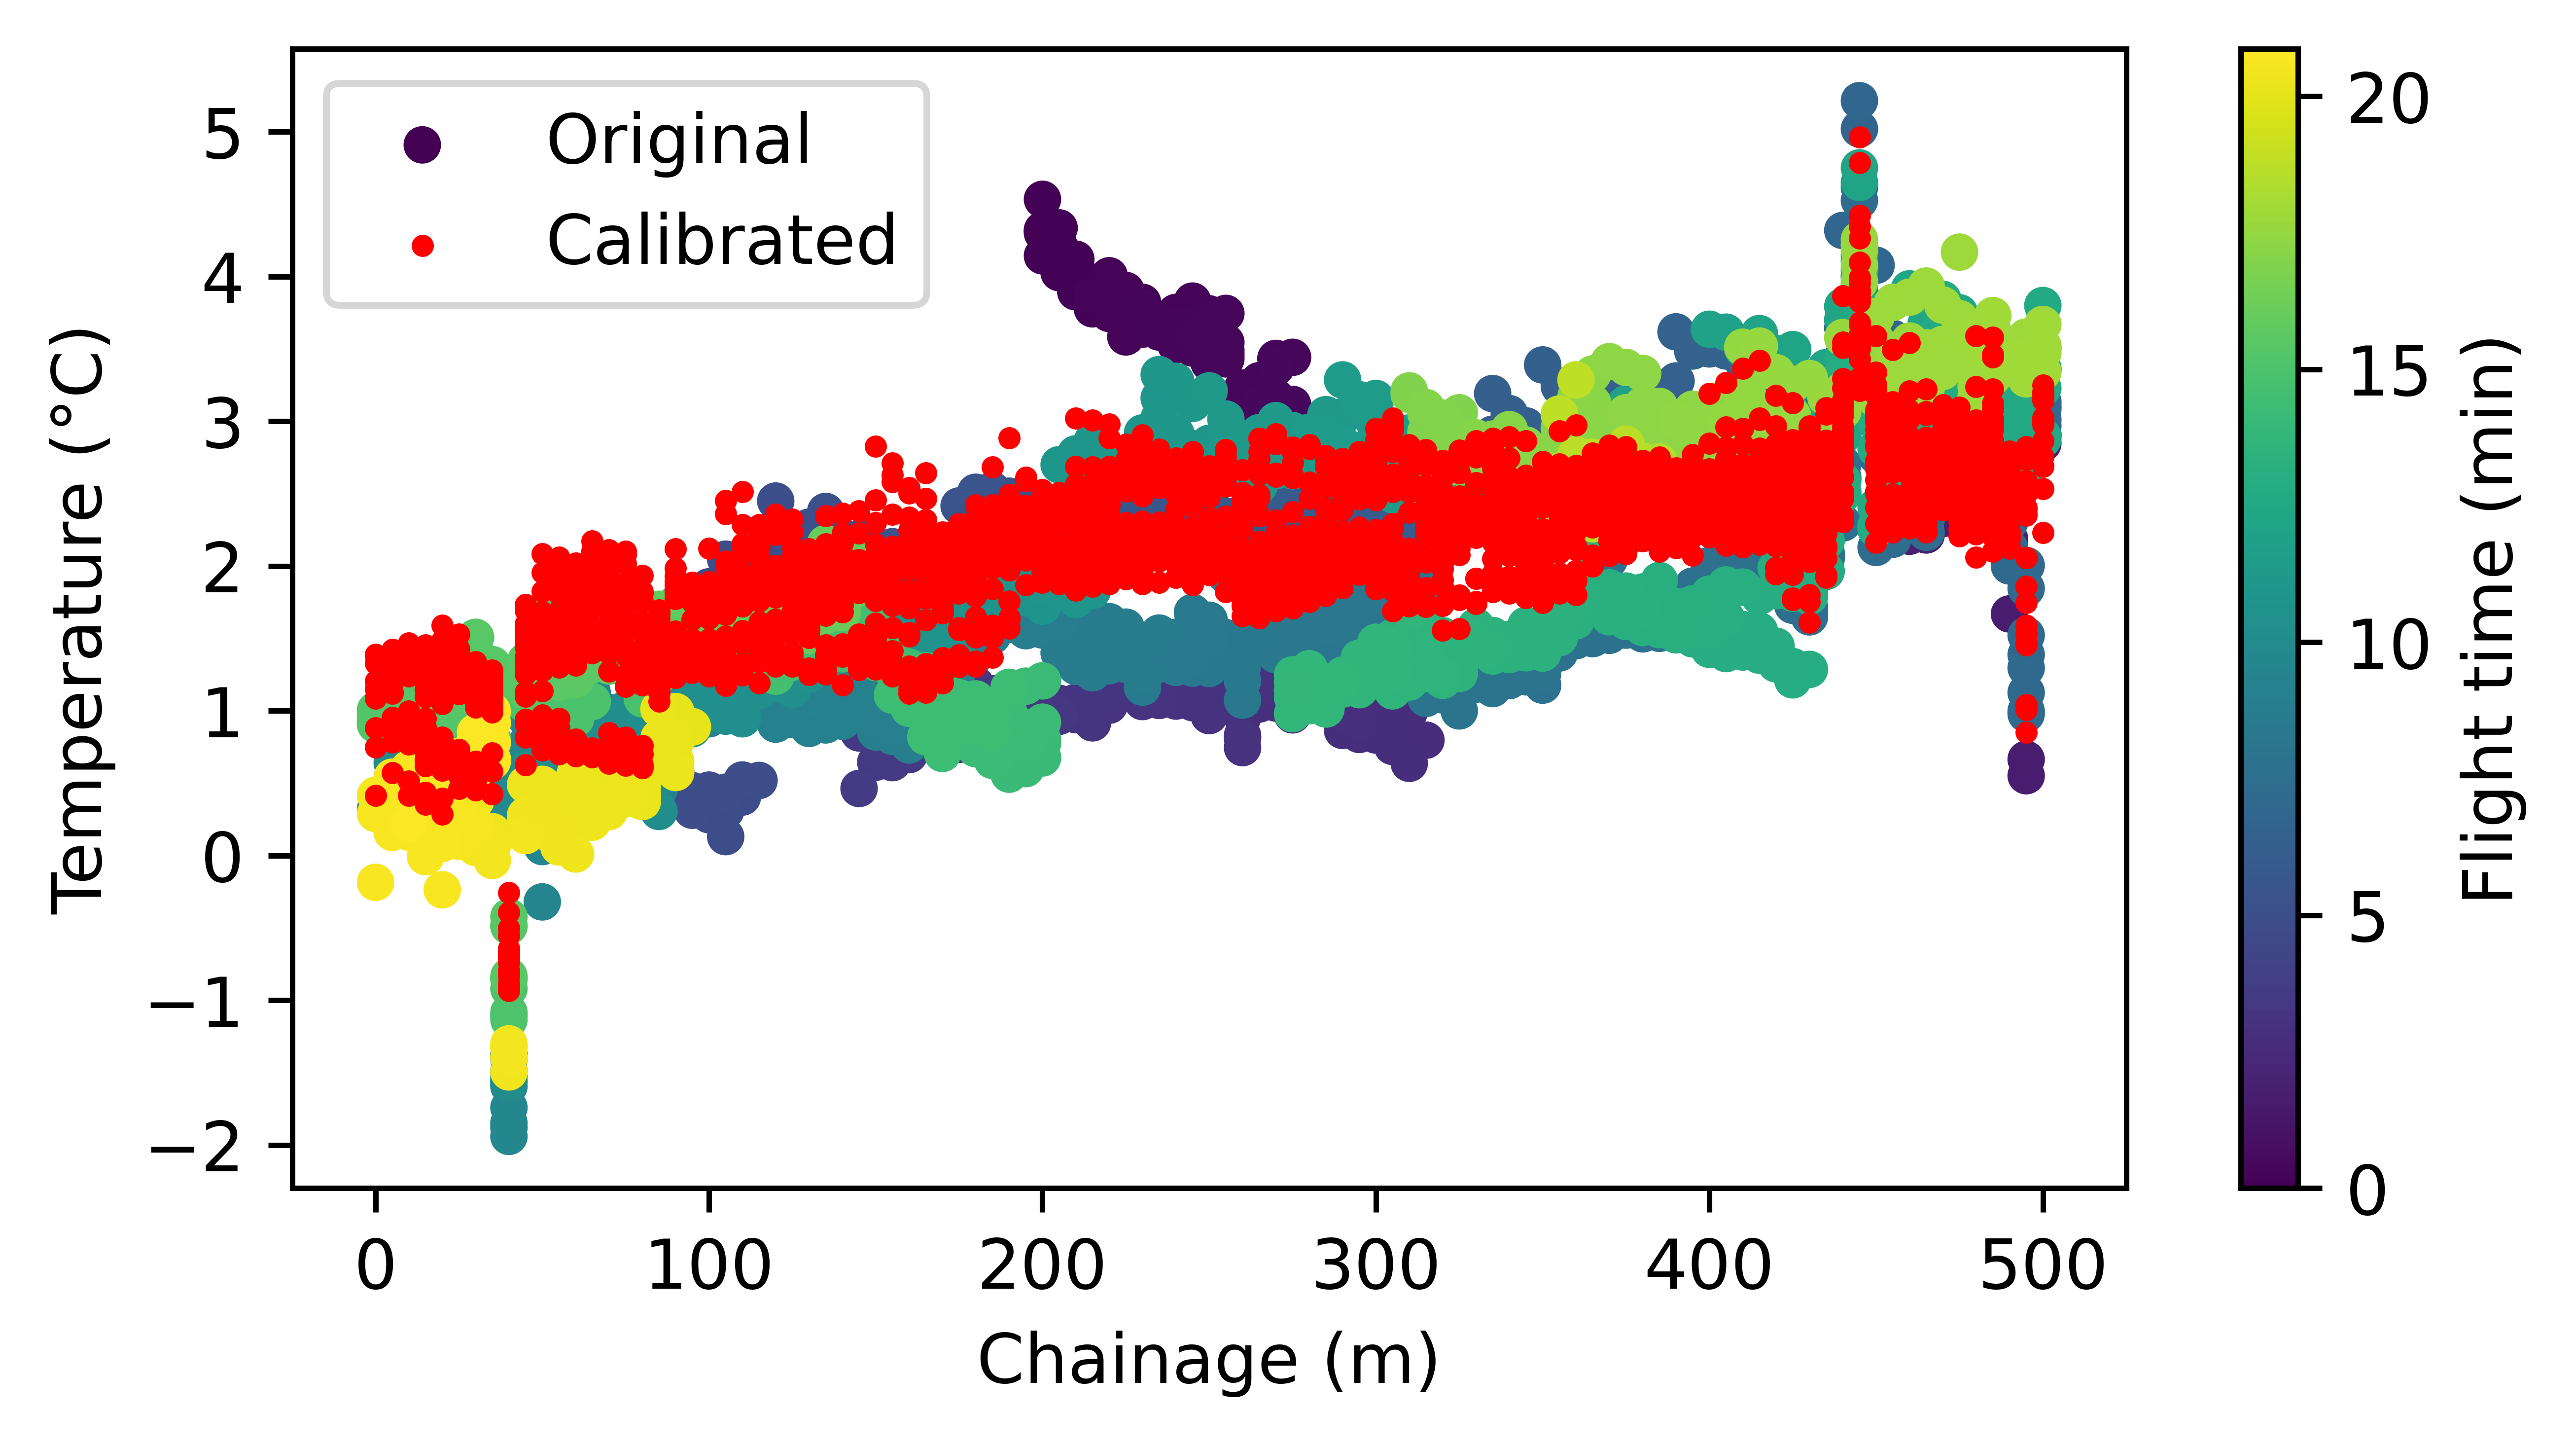

In [29]:
#plot temperature vs chainage vs time (color). Filter out chainages that are not in valid_chainages. Show legend.
fig, ax = plt.subplots(figsize=(6,3))
df_uncal.plot.scatter(x="chainage", y="temperature", c="time", colormap="viridis", ax=ax, label="Original")
df_cal.plot.scatter(x="chainage", y="temperature", c="red", colormap="viridis", ax=ax, label="Calibrated", s=5)
#set x label
ax.set_xlabel("Chainage (m)")
ax.set_ylabel("Temperature (°C)")
#update colorbar label
ax.collections[0].colorbar.set_label("Flight time (min)")
#set display dpi
plt.rcParams['figure.dpi'] = 1000
plt.show()


In [24]:
assert False

AssertionError: 

# Sample random points

In [ ]:
if CACHE and os.path.exists(f"{CACHE_DIR}/footprints.pkl"):
    with open(f"{CACHE_DIR}/footprints.pkl", "rb") as f:
        footprints = pickle.load(f)
else:
    geometries = []
    names = []
    for path in tqdm(glob(f"{GEOTIF_CAL_DIR}/*.tif")):
        raster = rxr.open_rasterio(path)
        footprints = rasterio.features.shapes((raster != raster.rio.nodata).values.astype(np.int16), transform=raster.rio.transform())
        footprints = [Polygon(geom["coordinates"][0]).simplify(10) for geom, colval in footprints if colval == 1]
        assert len(footprints) == 1, "More than one footprint found"
        names.append(os.path.basename(path))
        geometries.append(footprints[0])
    footprints = gpd.GeoDataFrame({"name": names, "geometry": geometries})
    #write CRS
    footprints.crs = CFG.CRS
    with open(f"{CACHE_DIR}/footprints.pkl", "wb") as f:
        pickle.dump(footprints, f)

NameError: name 'CFG' is not defined

In [ ]:
from rasterstats import zonal_stats
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

#footprints merged into one polygon
footprints_merged = footprints.unary_union
#find random 10 points inside the polygon
import random
from shapely.geometry import Point
points = []
while True:
    #get random x and y
    x = random.uniform(footprints_merged.bounds[0], footprints_merged.bounds[2])
    y = random.uniform(footprints_merged.bounds[1], footprints_merged.bounds[3])
    #create a point
    point = Point(x, y)
    #check if the point is inside the polygon
    if footprints_merged.contains(point):
        points.append(point)
    if len(points) == 30:
        break

#buffer the points by 1 meter
circles = [point.buffer(1) for point in points]
#plot points and footprints merged
gpd.GeoDataFrame(geometry=circles).plot()
gpd.GeoDataFrame(geometry=[footprints_merged]).plot(ax=plt.gca(), facecolor="none", edgecolor="red")
plt.show()

temperatures_cal = []
idx_cal = []
temperatures_uncal = []
idx_uncal = []
rasters = []
for (i, row), a, b in zip(footprints.iterrows(), tqdm(best_a_coefs, desc="Saving calibrated rasters"), best_b_coefs):
    geotif = rxr.open_rasterio(f"{GEOTIF_DEVIGNETTE_DIR}/{row['name']}", masked=True)
    geotif = geotif.rio.clip([row['geometry']])
    
    #use zonal stats to calculate mean value at circles
    stats = zonal_stats(circles, geotif.values[0], stats="mean", affine=geotif.rio.transform(), nodata=geotif.rio.nodata)

    for i, stat in enumerate(stats):
        if stat["mean"] != None:
            temperatures_uncal.append(stat["mean"])
            idx_uncal.append(i)
                
    geotif.values = a * geotif.values + b
    geotif.rio.to_raster(f"{GEOTIF_CAL_DIR}/{row['name']}")
    rasters.append(geotif)
    #use zonal stats to calculate mean value at circles
    stats = zonal_stats(circles, geotif.values[0], stats="mean", affine=geotif.rio.transform(), nodata=geotif.rio.nodata)
    for i, stat in enumerate(stats):
        if stat["mean"] != None:
            temperatures_cal.append(stat["mean"])
            idx_cal.append(i)

    # tif = rxr.open_rasterio(f"{TIF_UNCAL_DIR}/{name}", masked=True)
    # tif.values = a * tif.values + b
    # tif.rio.to_raster(f"{TIF_CAL_DIR}/{name}")
    # os.system(f"exiftool -tagsfromfile {TIF_UNCAL_DIR}/{name} {TIF_CAL_DIR}/{name} -overwrite_original_in_place")
